<a href="https://colab.research.google.com/github/neal-logan/dsba6211-summer2024/blob/main/notebooks/dsba6211_summer2024_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This assignment you are to partially use ChatGPT or LLM's but only for Problems 3 and 6 which are to aid you in interpreting the results. You are not to use ChatGPT or another LLM for Problems 1, 2, 4, 5 and 7. For those, you are to use the [reference material](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html) provided in class.**

# Dependencies

In [74]:
%%capture
!pip install skforecast
!pip install pmdarima

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Data

In [76]:
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1138&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=ENPLANE&scale=left&cosd=2000-01-01&coed=2024-02-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-06-27&revision_date=2024-06-27&nd=2000-01-01"

df = pd.read_csv(url, index_col=0, parse_dates=True)
df.head()

,ENPLANE
DATE,
2000-01-01,46492.0
2000-02-01,48526.0
2000-03-01,58764.0
2000-04-01,56032.0
2000-05-01,58201.0


In [77]:
# filter df only by 2010 to 2020
df = df['2010-01-01':'2019-12-31']

Train dates : 2010-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=108)
Test dates  : 2019-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=12)


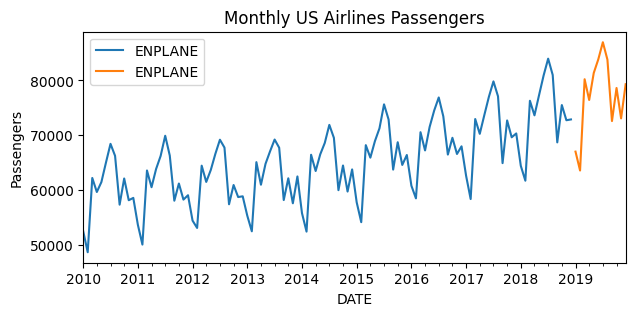

In [78]:
end_train = '2018-12-31 23:59:59'
print(
    f"Train dates : {df.index.min()} --- {df.loc[:end_train].index.max()}  "
    f"(n={len(df.loc[:end_train])})"
)
print(
    f"Test dates  : {df.loc[end_train:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[end_train:])})"
)
data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly US Airlines Passengers')
ax.set_ylabel('Passengers')
ax.legend();

Your goal is to develop a time series forecasting model for 2019 using 2010-2018 data as training.

# Problem 1: Visualizing Stationarity (No ChatGPT/LLM)

Use [this code](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Stationarity) to plot the train (2010-2018) data and the first/second order differences.

Use the code provided - **do not use ChatGPT** as it may provide alternative libraries code.

**Question**: What order (no difference, 1st order, or 2nd order) should you use to make the time series stationary?

Write 1-2 sentences justifying your answer.

Remember - you want to select the order that looks like it doesn't have any discernable patterns.

You do not need to run any statistical tests, but you can if you want further evidence.

**Response**:

The raw training data has seasonality and trend; the first-order diff also seems to have pretty clear seasonality.  Visually, the second-order diff also looks like it has seasonality, at least visually, and even the third- and fourth-order diffs seem to show some degree of seasonality (although it does seem to be decreasing with each successive diff).  On the other hand, the second-order diff passes the ADF statistical test for stationarity with an extremely low p-value (the first-order diff does not.)

If forced to choose between raw data, first-order diff, or second-order diff, I would choose the second-order diff, and this seems to be the conventionally-accepted choice.  However, in practice, I would prefer additional tests or analysis to rule out the visually-apparent seasonality before using this result in a modeling effort, or at least dive deeper into the way the ADF statistic is calculated to ensure that it does in fact account for all patterns of concern.


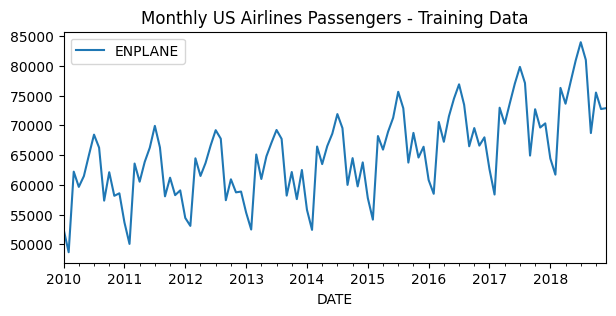

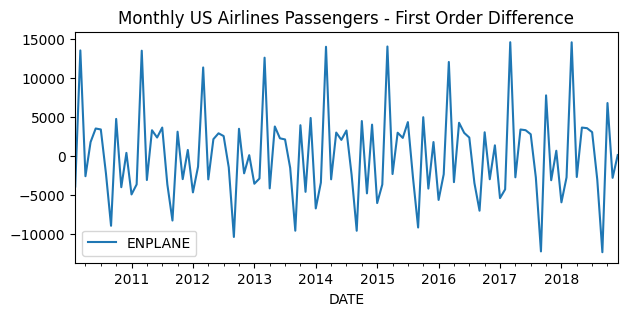

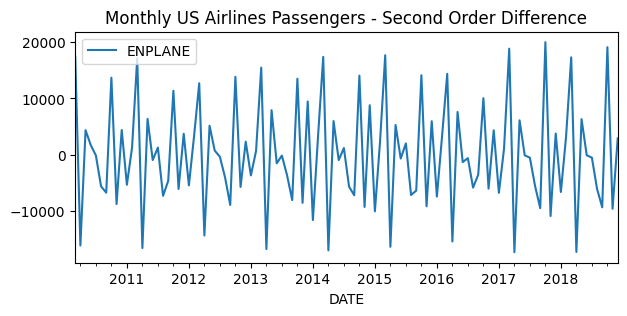

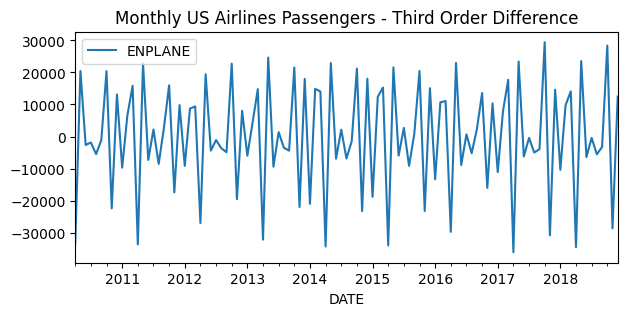

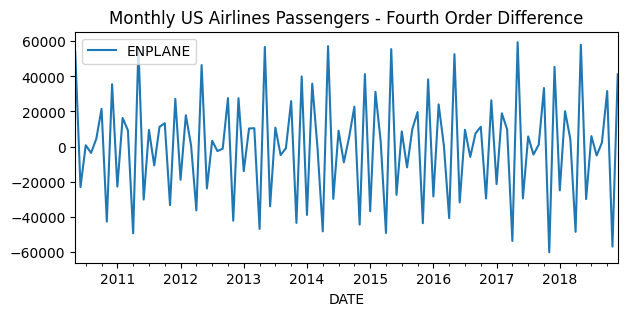

In [79]:
# add code here

#Take first- and second-order differences
data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()
data_diff_3 = data_diff_2.diff().dropna()
data_diff_4 = data_diff_3.diff().dropna()

#Plot training data
fig0, ax0=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax0, label='train')
ax0.set_title('Monthly US Airlines Passengers - Training Data')

fig1, ax1=plt.subplots(figsize=(7, 3))
data_diff_1.plot(ax=ax1, label='1st order difference')
ax1.set_title('Monthly US Airlines Passengers - First Order Difference')

fig2, ax2=plt.subplots(figsize=(7, 3))
data_diff_2.plot(ax=ax2, label='2nd order difference')
ax2.set_title('Monthly US Airlines Passengers - Second Order Difference')

fig3, ax3=plt.subplots(figsize=(7, 3))
data_diff_3.plot(ax=ax3, label='3rd order difference')
ax3.set_title('Monthly US Airlines Passengers - Third Order Difference')

fig4, ax4=plt.subplots(figsize=(7, 3))
data_diff_4.plot(ax=ax4, label='4th order difference')
ax4.set_title('Monthly US Airlines Passengers - Fourth Order Difference')

ax.legend();
plt.show()



Test stationarity for original series
-------------------------------------
ADF Statistic: 2.3890824957200727, p-value: 0.9990050788826677
KPSS Statistic: 1.3490282284590858, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -1.8161531296533324, p-value: 0.3724721137408976
KPSS Statistic: 0.05157750859463454, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -9.927725198122133, p-value: 2.877116378206007e-17
KPSS Statistic: 0.19524272063289386, p-value: 0.1


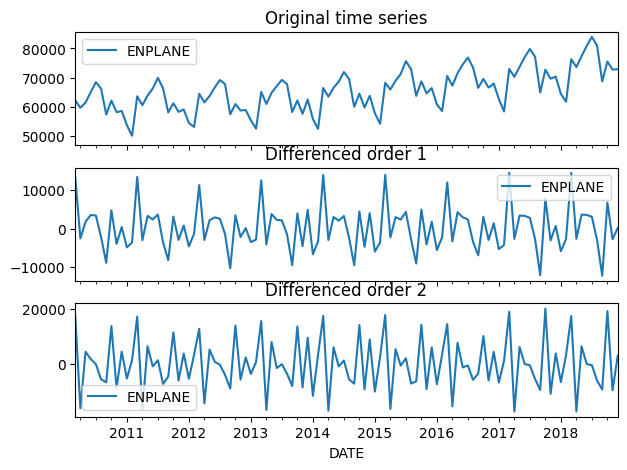

In [80]:
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data_train)
kpss_result = kpss(data_train)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data_train.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data_train.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data_train.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');


## Problem 2: ARIMA(1,d,1) (No ChatGPT/LLM)

Set up a ARIMA(1,d,1), where d is the order you selected in Problem 1.

- Use [`skforecast`](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Skforecast) (i.e., `Sarimax`) for ARIMA -- again, don't use ChatGPT as it may use a different library.

- Do not add any seasonal differences at this time (that is, do not provide values to `seasonal_order`)

Fit and run a summary stats on this model.

In [81]:
# add code here

# ARIMA model with skforecast.Sarimax
# ==============================================================================
model = Sarimax(order = (1, 2, 1))
model.fit(y=data_train)

#print summary statistics
model.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ENPLANE   No. Observations:                  108
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1080.495
Date:                Tue, 16 Jul 2024   AIC                           2166.989
Time:                        20:47:01   BIC                           2174.979
Sample:                    01-01-2010   HQIC                          2170.228
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0310      0.104     -0.297      0.766      -0.236       0.174
ma.L1         -0.9618      0.044    -22.087      0.000      -1.047      -0.876
sigma2      4.079e+07   9.13e-10   4.47e+16      0.000    4.08e+07    4.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 3.29
Prob(Q):                              0.30   Prob(JB):                         0.19
Heteroskedasticity (H):               0.76   Skew:                             0.37
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+32. Standard errors may be unstable.
"""

In [82]:
# Prediction
# ==============================================================================

predictions = model.predict(steps = 12)
predictions.head(4)



,pred
2019-01-01,73058.041686
2019-02-01,73231.182295
2019-03-01,73404.350861
2019-04-01,73577.518560


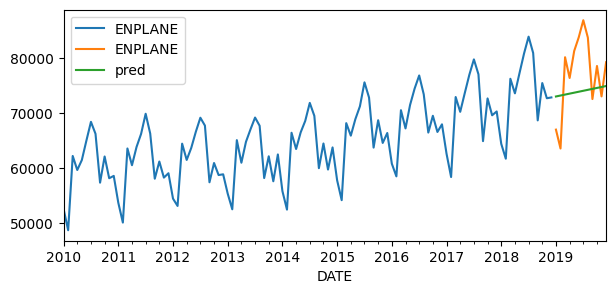

In [83]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [84]:
error_check = data_test.copy()
error_check['predictions'] = predictions
error_check['error'] = error_check['ENPLANE'] - error_check['predictions']
error_check.head(12)
#

,ENPLANE,predictions,error
DATE,,,
2019-01-01,67018.0,73058.041686,-6040.041686
2019-02-01,63577.0,73231.182295,-9654.182295
2019-03-01,80210.0,73404.350861,6805.649139
2019-04-01,76427.0,73577.518560,2849.481440
2019-05-01,81347.0,73750.686286,7596.313714
2019-06-01,83840.0,73923.854011,9916.145989
2019-07-01,86957.0,74097.021736,12859.978264
2019-08-01,83783.0,74270.189461,9512.810539
2019-09-01,72591.0,74443.357186,-1852.357186


## Problem 3: Interpretation (You may use ChatGPT/LLM)

Now interpret the results of your model from Problem 2.

For this, you **may** use ChatGPT or another LLM but you **must** provide your Share Link of your chat.

Assess your model's results - does it seem like your model fits the data well?

**Link**: https://chatgpt.com/share/125801db-dc32-4ccc-86fe-824da293cf77


**Response**: While the model passes a few statistical tests, including the significance of the moving average and well-behaved residuals (no autocorrelation, normal distribution, no heteroskedasticity), the overall amount of the variation in enplanement explained by the models is only about 40% according to the ChatGPT calculation (TODO check).  In some cases, this might be seen as a victory, but in this instance, the model totally ignores clear, large seasonal effects, meaning that producing a significantly better model should be reasonably straightforward.  The model does not fit the data well, almost entirely due to its failure to capture annual seasonality (12 monthly timesteps)



## Problem 4: ACF and PACF Plots (No ChatGPT/LLM)

Again, use [this code](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Autocorrelation-Analysis) and run ACF and PACF plots on the 0 (no difference), 1st, and 2nd order of your data. **Use the code in the plot** and don't use ChatGPT or else you may get different results.

Given your ACF and PACF plots for the order you choose in Problem 1: do you notice any seasonality patterns?

**Response:** In the ACF plots, the seasonality in both the original data and in the order-2 differenced data is clear.

In the PACF plots, there is perhaps a hint of seasonality in both the original data and the differenced data, but no clear pattern.



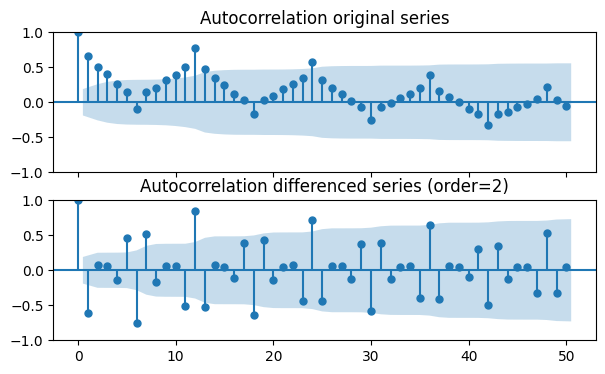

In [87]:
# add in code for ACF

# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(data_train, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_2, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=2)');

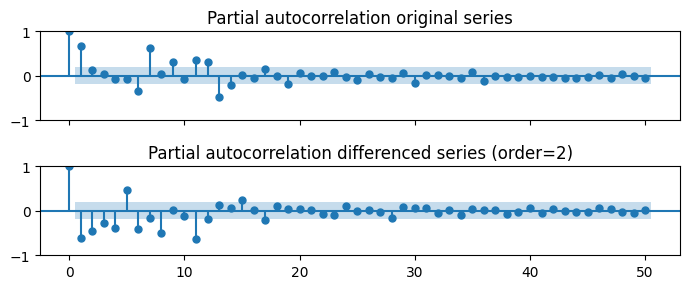

In [88]:
# add in code for PACF

# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(data_train, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_2, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=2)');
plt.tight_layout();

## Problem 5: Add in Seasonality Order (No ChatGPT/LLM)

Based on your answer for Problem 3, build a 2nd model and add in a `seasonal_order(1, 1, 1, s)` where `s` is the seasonal periodicity you decided from Problem 3.

In [90]:
# add in code

# ARIMA model with skforecast.Sarimax
# ==============================================================================
model_s = Sarimax(order = (1, 2, 1), seasonal_order = (1,1,1,12))
model_s.fit(y=data_train)

#print summary statistics
model_s.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            ENPLANE   No. Observations:                  108
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -856.222
Date:                            Tue, 16 Jul 2024   AIC                           1722.445
Time:                                    21:00:34   BIC                           1735.161
Sample:                                01-01-2010   HQIC                          1727.581
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4494      0.056      7.965      0.000       0.339       0.560
ma.L1         -0.8450      0.072    -11.721      0.000      -0.986      -0.704
ar.S.L12       0.9981     22.991      0.043      0.965     -44.063      46.060
ma.S.L12      -0.9983     23.110     -0.043      0.966     -46.293      44.296
sigma2      4.828e+06      0.002   2.77e+09      0.000    4.83e+06    4.83e+06
===================================================================================
Ljung-Box (L1) (Q):                  16.91   Jarque-Bera (JB):                13.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.31
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.71e+26. Standard errors may be unstable.
"""

In [91]:
# Prediction
# ==============================================================================

predictions_s = model_s.predict(steps = 12)
predictions_s.head(4)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pred
2019-01-01,66641.013551
2019-02-01,63679.178127
2019-03-01,78045.101000
2019-04-01,75198.605689


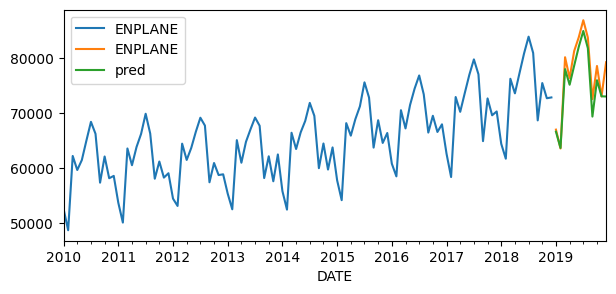

In [92]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_s.plot(ax=ax, label='predictions')
ax.legend();

In [96]:
error_check_s = data_test.copy()
error_check_s['predictions_seasonal'] = predictions_s
error_check_s['error'] = error_check_s['ENPLANE'] - error_check_s['predictions_seasonal']
error_check_s.head(12)
#

,ENPLANE,predictions_seasonal,error
DATE,,,
2019-01-01,67018.0,66641.013551,376.986449
2019-02-01,63577.0,63679.178127,-102.178127
2019-03-01,80210.0,78045.101000,2164.899000
2019-04-01,76427.0,75198.605689,1228.394311
2019-05-01,81347.0,78683.595113,2663.404887
2019-06-01,83840.0,82095.401846,1744.598154
2019-07-01,86957.0,84997.941648,1959.058352
2019-08-01,83783.0,81852.094994,1930.905006
2019-09-01,72591.0,69395.011628,3195.988372


## Problem 6: Use ChatGPT to compare and interpret both plots

- Create a prompt to compare the results of both Model 1 and Model 2.

- Provide the ChatGPT shared link.

- Based on the model statistics, which model fits the training data better?

- What factors should you also consider when making model selection?

**Link:** https://chatgpt.com/share/2b50702b-498a-41bb-94c1-c6fc7afe1f55

**Response:** Based on model statistics including log likelihood and information criterian measures, Model 2 (seasonal) is a much better fit.  Model 1 passes all of its statistical tests, while Model 2 does not; Model 2 shows signs of autocorrelation and non-normally distributed residuals.  We'd want to consider this when improving or using the model.  However, for near-term predictions, we can already expect Model 2 to produce predictions much closer to actual values, as demonstrated by a comparison of RMSE for 2019 data.
    


## Problem 7: Forecasting (No ChatGPT/LLM)

Now use the code below to use your models to forecast for 2019.

The code below assumes your models have the following:
1. Model 1 is named `arima`
2. Model 2 (with seasonality) is named `arima2`

Modify these accordingly to predict your data.

In [ ]:
predictions_skforecast = arima.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']

fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_skforecast.plot(ax=ax, label='skforecast')
ax.set_title('Predictions with ARIMA models')
ax.legend();

In [ ]:
predictions_skforecast2 = arima2.predict(steps=len(data_test))
predictions_skforecast2.columns = ['skforecast']
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_skforecast2.plot(ax=ax, label='skforecast')
ax.set_title('Predictions with ARIMA models')
ax.legend();

Answer these questions, each in 1-2 sentences:

- What is the difference between the two models forecast?

- Visually, which of the two models seem to fit your data out-of-sample (test/2019) data better?

- What are problems you still visualize with your selected model?